# Multiclass Perceptron

In the previous discussion we've gone over a perceptron with only 2 classes. In this notebook we'll show how it can work on multiple classes.


In [38]:
# Import all required libraries
from __future__ import division # For python 2.*

import numpy as np
import matplotlib.pyplot as plt
import utils as ml

np.random.seed(0)
%matplotlib inline

# Data Sampling

In [39]:
x_0 = np.random.normal(loc=[-4, 2], scale=0.5, size=(100, 2))
x_1 = np.random.normal(loc=[-4, -3], scale=0.5, size=(100, 2))
x_2 = np.random.normal(loc=[4, 1], scale=0.5, size=(100, 2))
x_3 = np.random.normal(loc=[5, -2], scale=0.5, size=(100, 2))

X = np.vstack([x_0, x_1, x_2, x_3])
Y = np.ones(X.shape[0], dtype=np.intc)
Y[:100] = 0
Y[100:200] = 1
Y[200:300] = 2
Y[300:] = 3

/Users/harryxiong24/Code/Study/machine-learning-collection/linear-classification/native/utils/plot.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axis.plot( X[Y==c,0],X[Y==c,1], 'ko', color=cmap(cvals[i]), **kwargs )


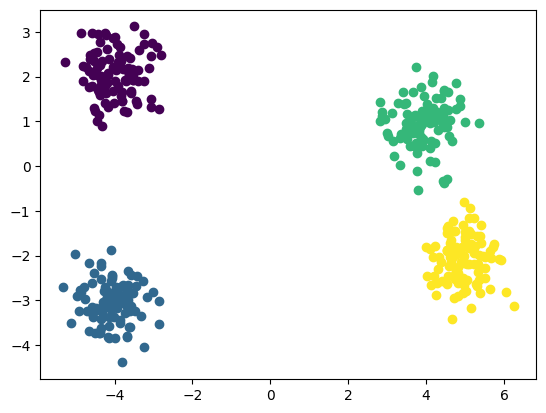

In [40]:
ml.plotClassify2D(None, X, Y)

In [41]:
classes = np.unique(Y)
print(classes)

[0 1 2 3]


## Multiclass Perceptron Training Algorithm

One of the main differences is that now there is a $\theta_c$ for each class. So in the algorithm above $\theta$ is basically size $\#Classes \times \#Features$.

To find the class, instead of using the sign threshold on the response, we are looking for the class that maximizes the response.

So let's adapt the code from the previous discussion to do this.


Let's add the const to the X and create the theta matrix.


In [42]:
# Like previous discussion
def add_const(X):
    return np.hstack([np.ones([X.shape[0], 1]), X])

In [43]:
Xconst = add_const(X)
theta = np.random.randn(
    classes.shape[0], Xconst.shape[1]
)  # Adding 1 for theta corresponding to bias term

x_j, y_j = Xconst[5], Y[5]
print(Xconst.shape, theta.shape)

(400, 3) (4, 3)


In [44]:
# The response is also the same, only we transpose the theta.
def resp(x, theta):
    return np.dot(x, theta.T)

For the predict we need to find the class that maximizes the response. We can do this with np.argmax().


In [45]:
def predict(x, theta):
    r = resp(x, theta)
    return np.argmax(np.atleast_2d(r), axis=1)


# Error stays the same
def pred_err(X, Y, theta):
    """Predicts that class for X and returns the error rate."""
    Yhat = predict(X, theta)
    return np.mean(Yhat != Y)

In [46]:
pred_vals = predict(x_j, theta)
print("Predicted class %d, True class is %d" % (pred_vals, y_j))

Predicted class 3, True class is 0


/var/folders/mf/1zht4rt167l4nwkf7l1df8rh0000gn/T/ipykernel_36694/1623696430.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted class %d, True class is %d" % (pred_vals, y_j))


## Learning Update

In [47]:
a = 0.1
y_j_hat = predict(x_j, theta)
if y_j == y_j_hat:
    print("Good! No change would be made at this point")
else:
    theta[y_j_hat] -= a * x_j
    theta[y_j] += a * x_j

## Train method

Using everything we coded so far, let's code the training method.


In [48]:
def train(X, Y, a=0.01, max_iter=50):
    Xconst = add_const(X)
    m, n = Xconst.shape
    c = np.unique(Y).shape[0]

    # Initializing theta
    theta = np.random.rand(c, n)

    # The update loop
    J_err = [np.inf]
    for i in xrange(1, max_iter + 1):
        for j in range(m):
            x_j, y_j = Xconst[j], Y[j]
            y_j_hat = predict(x_j, theta)
            if y_j == y_j_hat:
                continue
            theta[y_j_hat] -= a * x_j
            theta[y_j] += a * x_j

        curr_err = pred_err(Xconst, Y, theta)
        J_err.append(curr_err)

        print("Error %.3f at iteration %d" % (J_err[-1], i))

    return theta, J_err

## Multiclass Perceptron Object

Let us put this all in a class MultiPerceptron.


In [49]:
from utils.base import classifier


class MultiClassPerceptron(classifier):
    def __init__(self, theta=None):
        self.theta = theta

    def add_const(self, X):
        return np.hstack([np.ones([X.shape[0], 1]), X])

    def resp(self, x):
        return np.dot(x, self.theta.T)

    def predict(self, X):
        """Retruns class prediction for either single point or multiple points."""
        Xconst = np.atleast_2d(X)

        # Making sure it has the const, if not adding it.
        if Xconst.shape[1] == self.theta.shape[1] - 1:
            Xconst = self.add_const(Xconst)

        r = self.resp(Xconst)
        return np.argmax(np.atleast_2d(r), axis=1)

    # Notice that we don't need the sign function (from Perceptron class) any longer
    #     def sign(self, vals):
    #         """A sign version with breaking 0's as +1. """
    #         return np.sign(vals + 1e-200)

    def pred_err(self, X, Y):
        Yhat = self.predict(X)
        return np.mean(Yhat != Y)

    def train(self, X, Y, a=0.01, max_iter=50):
        # Start by adding a const
        Xconst = self.add_const(X)

        m, n = Xconst.shape
        c = np.unique(Y).shape[0]
        self.classes = np.unique(Y)

        # Making sure Theta is inititialized.
        if self.theta is None:
            self.theta = np.random.randn(c, n)

        # The update loop
        J_err = [np.inf]
        for i in range(1, max_iter + 1):
            for j in np.random.permutation(m):
                x_j, y_j = Xconst[j], Y[j]
                y_j_hat = self.predict(x_j)
                if y_j == y_j_hat:
                    continue
                self.theta[y_j_hat[0]] -= a * x_j
                self.theta[y_j] += a * x_j

            curr_err = self.pred_err(Xconst, Y)
            J_err.append(curr_err)

        return J_err

Let's train and plot :)


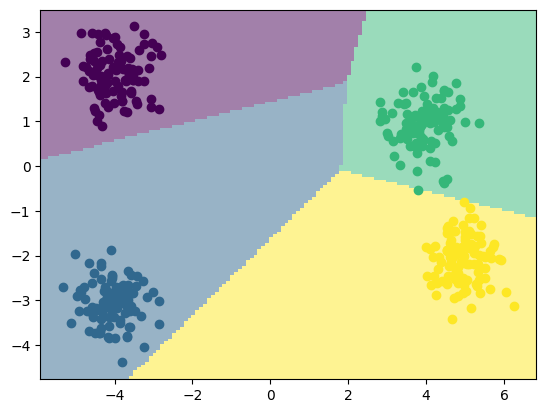

In [50]:
model = MultiClassPerceptron()
j_err = model.train(X, Y, a=0.01, max_iter=300)
ml.plotClassify2D(model, X, Y)

## A fun quiz (optional)

In the plot below we have two classes. Let's assume that I want to have multiclass perceptron with 2 classes, what would theta have to be to separate them correctly?


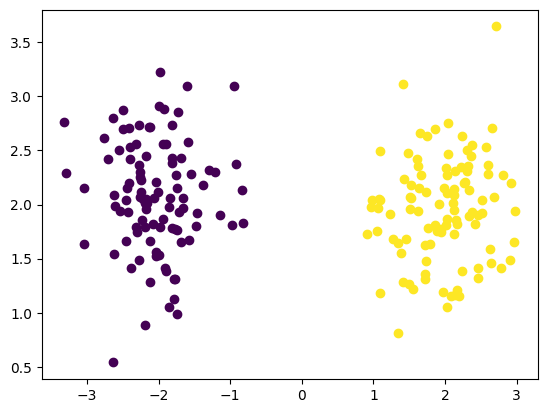

In [51]:
x_0 = np.random.normal(loc=[-2, 2], scale=0.5, size=(100, 2))
x_1 = np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2))

X = np.vstack([x_0, x_1])
Y = np.ones(X.shape[0], dtype=np.intc)
Y[:100] = 0
Y[100:200] = 1

ml.plotClassify2D(None, X, Y)

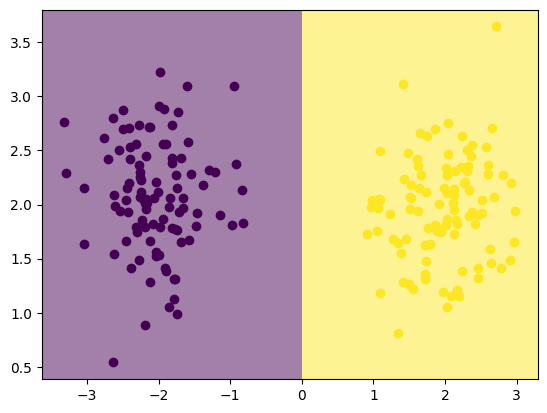

In [52]:
# theta_quiz = ?   # Fill in the code and run
theta_quiz = np.array([[0, -1, 0], [0, 1, 0]])  # Fill in the code and run
model = MultiClassPerceptron(theta_quiz)
ml.plotClassify2D(model, X, Y)

# Train a multiclassifier using PyTorch

In [53]:
import torch
import torch.nn as nn

In [54]:
# prepare data
x_0 = np.random.normal(loc=[-4, 2], scale=0.5, size=(100, 2))
x_1 = np.random.normal(loc=[-4, -3], scale=0.5, size=(100, 2))
x_2 = np.random.normal(loc=[4, 1], scale=0.5, size=(100, 2))
x_3 = np.random.normal(loc=[5, -2], scale=0.5, size=(100, 2))

X = np.vstack([x_0, x_1, x_2, x_3])
Y = np.ones(X.shape[0], dtype=np.intc)
Y[:100] = 0
Y[100:200] = 1
Y[200:300] = 2
Y[300:] = 3

In [55]:
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).long().squeeze()

In [56]:
# construct model
class My_Classifier(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.layer = nn.Linear(n_features, n_classes)
        self.log_soft_max = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.layer(x)
        return self.log_soft_max(x)

In [57]:
my_classifier = My_Classifier(2, 4)

In [58]:
criterior = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(my_classifier.parameters(), lr=0.1, momentum=0.9)

In [59]:
def get_accuracy(out, target_y):
    pred_y = torch.argmax(out, dim=1)
    accuracy = torch.sum(pred_y == target_y) / len(Y)
    return accuracy

In [60]:
for i in range(1000):
    optimizer.zero_grad()
    out = my_classifier(X)
    accuracy = get_accuracy(out, Y)
    loss = criterior(out, Y)
    print(loss.item(), accuracy.item())
    loss.backward()
    optimizer.step()

1.7951382398605347 0.25
1.2068538665771484 0.5
0.6798577904701233 0.7599999904632568
0.44299912452697754 0.949999988079071
0.30979084968566895 0.9925000071525574
0.2101389318704605 0.9975000023841858
0.14217066764831543 1.0
0.099447101354599 1.0
0.07280399650335312 1.0
0.05568907409906387 1.0
0.04424772784113884 1.0
0.03629656881093979 1.0
0.030578535050153732 1.0
0.026344921439886093 1.0
0.023132355883717537 1.0
0.020643072202801704 1.0
0.018678968772292137 1.0
0.0171042513102293 1.0
0.01582339033484459 1.0
0.014767824672162533 1.0
0.013887451961636543 1.0
0.013145141303539276 1.0
0.012513059191405773 1.0
0.011970097199082375 1.0
0.011500077322125435 1.0
0.011090463027358055 1.0
0.010731385089457035 1.0
0.010415026918053627 1.0
0.010135038755834103 1.0
0.009886253625154495 1.0
0.009664345532655716 1.0
0.009465712122619152 1.0
0.009287266992032528 1.0
0.009126385673880577 1.0
0.00898079015314579 1.0
0.008848548866808414 1.0
0.00872797891497612 1.0
0.00861761998385191 1.0
0.008516236208

In [61]:
# let's do the prediction
pred_y = torch.argmax(my_classifier(X), dim=1)
# calculate accuracy
accuracy = torch.sum(pred_y == Y) / len(Y)
print(accuracy.item())

1.0
